In [1]:
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

## Goals:
---
- **Implement kernel logistic regression**
- **Implement kernel SVM**

***
Utilities
----
***

In [2]:
import cvxopt

def cvxopt_qp(P, q, G, h, A, b):
    P = .5 * (P + P.T)
    cvx_matrices = [
        cvxopt.matrix(M) if M is not None else None for M in [P, q, G, h, A, b] 
    ]
    #cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(*cvx_matrices, options={'show_progress': False})
    return np.array(solution['x']).flatten()

solve_qp = cvxopt_qp

### Data generation

In [212]:
# Simulate data
np.random.seed(54321)
p = 2

def generate_Xy(n_samples, p=2, sigma=1):
    # Half of y is 1s, other half is -1
    y = np.ones(n_samples)
    mid = int(n_samples / 2)
    y[mid:] *= -1
    
    X = np.random.normal(0, sigma, (n_samples, p))
    X[y == 1] /= 10
    X += (1 - y[:, np.newaxis]) / 2 # add 1 when y = -1
    # X of shape (n, p)
    # y vector of length n
    return X, y

# Training data
X_train, y_train = generate_Xy(100, sigma=2)

# Testing data
X_test, y_test = generate_Xy(1000, sigma=2)

# Normalize data
mu_train, sigma_train = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu_train) / sigma_train
X_test = (X_test - mu_train) / sigma_train

In [214]:
X_test.mean(axis=0)

array([ 0.06606413, -0.17340843])

### Plotting

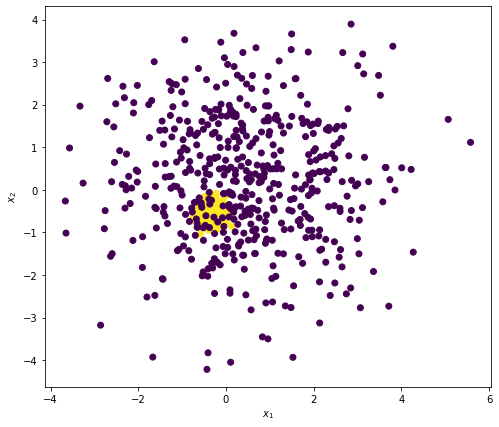

In [215]:
# Visualize training data
def plot_data(X, y):
    plt.figure(figsize=(8,7))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()
    
plot_data(X_test, y_test)

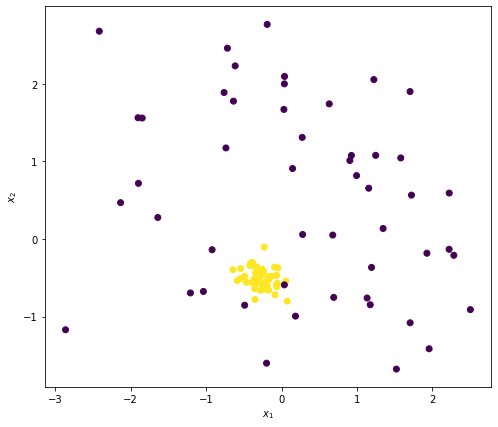

In [216]:
plot_data(X_train, y_train)

In [217]:
# Visualize training data and separating hyperplane
def compute_margins(b, w1, w2, x1):
    '''
    returns x2 such that:
        - f(x) = 0
        - f(x) = 1
        - f(x) = -1
    '''
    x2 = (-b - w1 * x1) / w2
    x2_up = (-b - w1 * x1 - 1) / w2
    x2_low = (-b - w1 * x1 + 1) / w2
    
    return x2, x2_up, x2_low

def plot_points_with_margin(X, y, w, b):
    plt.figure(figsize=(8,7))

    # Training data
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

    # Separating hyperplane and decision boundaries
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    w1, w2 = w
    x2, x2_up, x2_low = compute_margins(b, w1, w2, x1)

    plt.plot(x1, x2, 'b')
    plt.plot(x1, x2_up, 'b--')
    plt.plot(x1, x2_low, 'b--')

    # Plot
    plt.show()

[LibLinear]w [-0.9465789  -1.47224574]
b [0.0310772]
......*
optimization finished, #iter = 66
Objective value = -46.125379
nSV = 48


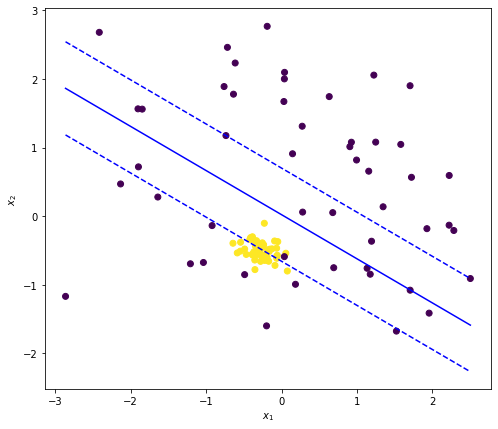

In [218]:
from sklearn.svm import LinearSVC

clf = LinearSVC(penalty='l2', loss='hinge', C=1., verbose=1)
# Train the model
clf.fit(X_train, y_train)
print('w', clf.coef_[0])
print('b', clf.intercept_)
plot_points_with_margin(X_train, y_train, clf.coef_[0], clf.intercept_[0])

In [219]:
# Prediction error
def error(ypred, ytrue):
    e = (ypred != ytrue).mean()
    return e

def add_column_ones(X):
    n = X.shape[0]
    return np.hstack([X, np.ones((n, 1))])

# Visualization
# References: https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(classifier, xx, yy, add_intercept=False, **params):
    """Plot the decision boundaries for a classifier.
    
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X = np.c_[xx.ravel(), yy.ravel()]
    Z = classifier.predict(X)#, fit_intercept=add_intercept)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def plot_decision_function(classifier, X_train, y_train, title='', add_intercept=False):
    fig = plt.figure(figsize=(8,7))
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(classifier, xx, yy, cmap=plt.cm.GnBu, alpha=0.5, add_intercept=add_intercept)
    plt.scatter(X0, X1, c=y_train, cmap=plt.cm.GnBu, s=20, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.show()

***
Example kernel implementations
----
***

In [220]:
def rbf_kernel(X1, X2, sigma=10):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the RBF kernel with parameter sigma
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    sigma: float
    '''
    # For loop with rbf_kernel_element works but is slow in python
    # Use matrix operations!
    X2_norm = np.sum(X2 ** 2, axis = -1)
    X1_norm = np.sum(X1 ** 2, axis = -1)
    gamma = 1 / (2 * sigma ** 2)
    K = np.exp(- gamma * (X1_norm[:, None] + X2_norm[None, :] - 2 * np.dot(X1, X2.T)))
    return K

def sigma_from_median(X):
    '''
    Returns the median of ||Xi-Xj||
    
    Input
    -----
    X: (n, p) matrix
    '''
    pairwise_diff = X[:, :, None] - X[:, :, None].T
    pairwise_diff *= pairwise_diff
    euclidean_dist = np.sqrt(pairwise_diff.sum(axis=1))
    return np.median(euclidean_dist)

In [221]:
def linear_kernel(X1, X2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the linear kernel
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return ...

def polynomial_kernel(X1, X2, degree=2):
    '''
    Returns the kernel matrix K(X1_i, X2_j): size (n1, n2)
    where K is the polynomial kernel of degree `degree`
    
    Input:
    ------
    X1: an (n1, p) matrix
    X2: an (n2, p) matrix
    '''
    return ...

***
# Kernel Methods
***

*Kernel trick in a nutshell:*
1. In the optimization problem and in the decision function, **express all dependencies on the data $X$ by scalar products $X_1 X_2^\top$**
2. **Replace these scalar products $X_1 X_2^\top$ by kernel matrices $K_{X_1, X_2}$** slide 123

What we are doing:

Training a model on data $\Phi(X_{train})$, where $\Phi$ is a transformation.

$K(x, y) = \Phi(x)^\top \Phi(y)$

In [222]:
class KernelMethodBase(object):
    '''
    Base class for kernel methods models
    
    Methods
    ----
    fit
    predict
    fit_K
    predict_K
    '''
    kernels_ = {
        'linear': linear_kernel,
        'polynomial': polynomial_kernel,
        'rbf': rbf_kernel,
        # 'mismatch': mismatch_kernel,
    }
    def __init__(self, kernel='linear', **kwargs):
        self.kernel_name = kernel
        self.kernel_function_ = self.kernels_[kernel]
        self.kernel_parameters = self.get_kernel_parameters(**kwargs)
        self.fit_intercept_ = False
        
    def get_kernel_parameters(self, **kwargs):
        params = {}
        if self.kernel_name == 'rbf':
            params['sigma'] = kwargs.get('sigma', 1.)
        if self.kernel_name == 'polynomial':
            params['degree'] = kwargs.get('degree', 2)
        return params

    def fit_K(self, K, y, **kwargs):
        pass
        
    def decision_function_K(self, K):
        pass
    
    def fit(self, X, y, fit_intercept=False, **kwargs):

        if fit_intercept:
            X = add_column_ones(X)
            self.fit_intercept_ = True
        self.X_train = X
        self.y_train = y

        K = self.kernel_function_(self.X_train, self.X_train, **self.kernel_parameters)

        return self.fit_K(K, y, **kwargs)
    
    def decision_function(self, X):

        if self.fit_intercept_:
            X = add_column_ones(X)

        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)

        return self.decision_function_K(K_x)

    def predict(self, X):
        pass
    
    def predict_K(self, K):
        pass

### Kernel Ridge Regression
First a reminder on Kernel Ridge Regression:

The prediction rule is:
$$\hat{y}(X_t) = \color{darkorange}{X_t X^\top}(\color{darkorange}{XX^\top} + \lambda n I)^{-1} y$$

*Kernel trick:* Replace $\color{darkorange}{X X^\top}$ with $\color{darkorange}{K_{X,X}}$

#### Adding weights:
To transform into Weighted Kernel Ridge Regression, with non-negative weights $w$ set:
- $W = \mathrm{Diag}(\sqrt{w})$
- $\tilde{X} = WX$, $\tilde{y} = Wy$

In [223]:
class KernelRidgeRegression(KernelMethodBase):
    '''
    Kernel Ridge Regression
    '''
    def __init__(self, lambd=0.1, **kwargs):
        self.lambd = lambd
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelRidgeRegression, self).__init__(**kwargs)

    def fit_K(self, K, y, sample_weights=None):
        n = K.shape[0]
        assert (n == len(y))
        
        w_sqrt = np.ones_like(y) if sample_weights is None else sample_weights
        w_sqrt = np.sqrt(w_sqrt)

        # Rescale kernel matrix K to take weights into account
        A = ...
        # Add n*lambda to the diagonal of A (= add n*lambda*I):
        # self.alpha = (K + n lambda I)^-1 y
        self.alpha = np.linalg.solve(A , ...)

        return self
    
    def decision_function_K(self, K_x):
        return K_x.dot(self.alpha)
    
    def predict(self, X):
        return self.decision_function(X)
    
    def predict_K(self, K_x):
        return self.decision_function_K(K_x)

Test

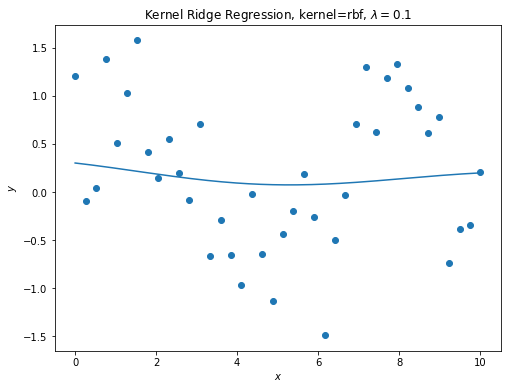

In [263]:
xtrain = np.linspace(0, 10, 40)
ytrain = np.sin(xtrain) + 0.5 * np.random.randn(len(xtrain))
xtest = np.linspace(0, 10, 200)

kernel = 'rbf'
lambd = 0.1
sigma = 5.
model = KernelRidgeRegression(
        kernel=kernel,
        lambd=lambd,
        sigma=sigma
    ).fit(xtrain[:, None], ytrain)
ypred = model.predict(xtest[:, None])

plt.figure(figsize=(8, 6))
plt.scatter(xtrain, ytrain)
plt.plot(xtest, ypred)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Kernel Ridge Regression, kernel={}, $\lambda=${}'.format(kernel, lambd))
plt.show()

To perform binary classification with Ridge:

Train with y = -1 and 1

```predictions = np.sign(model.predict(X))```

In [255]:
class KernelRidgeClassifier(KernelRidgeRegression):
    '''
    Kernel Ridge Classification
    '''
    def predict(self, X):
        return ...

    def predict_K(self, K):
        return ...

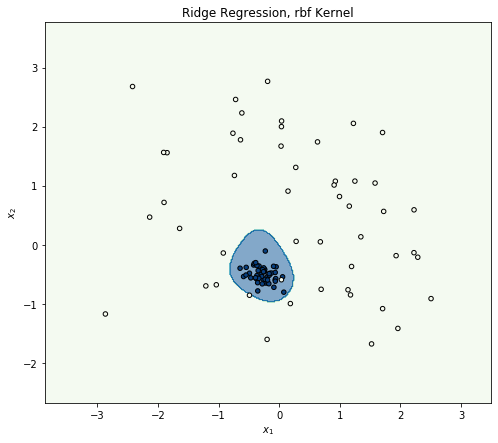

Test error: 4.70%


In [257]:
kernel = 'rbf'

kernel_parameters = {
    'degree': 2,
    'sigma': .5,
}
lambd = 0.001

training_parameters = {
    'fit_intercept': False
}

model = KernelRidgeClassifier(lambd=lambd, kernel=kernel, **kernel_parameters)

model.fit(X_train, y_train, **training_parameters)

y_pred = model.predict(X_test)

fig_title = 'Ridge Regression, {} Kernel'.format(kernel)
plot_decision_function(model, X_train, y_train, title=fig_title)
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

***
## Kernel SVM
***

- **Soft-margin dual problem:**
$$
\begin{aligned}
\max_\alpha & \, \mathrm{1}^\top\alpha -\frac{1}{2}\alpha^\top y_{diag} \color{darkorange}{X X^\top} y_{diag} \alpha \\
\mathrm{s.t. } \, & \alpha \geq 0 \\
& \alpha \leq C \\
& y^\top\alpha = 0
\\
\end{aligned}
$$

 *Kernel trick:* Replace $\color{darkorange}{X X^\top}$ with $\color{darkorange}{K_{X,X}}$
 
- **Decision function**
$$f(X_{test}) = X_{test} w + b$$
 - $w = \sum_{i=1}^n \alpha_i y_i x_i$
 - $b = y_{i^*} - w^\top x_{i^*}$ for support vectors $i^*$
 
 *Kernel trick:* Rewrite $f(X_{test})$ using only the kernel $K$
 
 $$f(X_{test}) = \color{darkorange}{X_{test}X_{train}^\top} \beta + b$$
 where:
  - $\beta := \alpha \odot y$ is the elementwise product of $\alpha$ and $y$ ($\beta_i = \alpha_i y_i$)
  - $b$ is the average of $\color{darkorange}{X_{sv} X_{train}^\top} \beta$
  
  $sv$ = support vectors = subset of training vectors

Remember: Replace $\color{darkorange}{X_1 X_2^\top}$ with $\color{darkorange}{K_{X_1,X_2}}$

In [98]:
def svm_dual_soft_to_qp_kernel(K, y, C=1):
    n = K.shape[0]
    assert (len(y) == n)
        
    # Dual formulation, soft margin
    P = ...
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)
    q = - np.ones(n)
    G = np.vstack([-np.eye(n), np.eye(n)])
    h = np.hstack([np.zeros(n), C * np.ones(n)])
    A = y[np.newaxis, :]
    b = np.array([0.])
    return P, q, G, h, A, b

K = linear_kernel(X_train, X_train)
alphas = solve_qp(*svm_dual_soft_to_qp_kernel(K, y_train, C=1.))

In [99]:
class KernelSVM(KernelMethodBase):
    '''
    Kernel SVM Classification
    
    Methods
    ----
    fit
    predict
    '''
    def __init__(self, C=0.1, **kwargs):
        self.C = C
        # Python 3: replace the following line by
        # super().__init__(**kwargs)
        super(KernelSVM, self).__init__(**kwargs)

    def fit(self, X, y, tol=1e-3):
        n, p = X.shape
        assert (n == len(y))
    
        self.X_train = X
        self.y_train = y
        
        # Kernel matrix
        K = self.kernel_function_(
            self.X_train, self.X_train, **self.kernel_parameters)
        
        # Solve dual problem
        self.alpha = solve_qp(*svm_dual_soft_to_qp_kernel(K, y, C=self.C))
        
        # Compute support vectors and bias b
        sv = np.logical_and((self.alpha > tol), (self.C - self.alpha > tol))
        self.bias = ...

        self.support_vector_indices = np.nonzero(sv)[0]

        return self
        
    def decision_function(self, X):
        K_x = self.kernel_function_(X, self.X_train, **self.kernel_parameters)
        return ...

    def predict(self, X):
        return np.sign(self.decision_function(X))

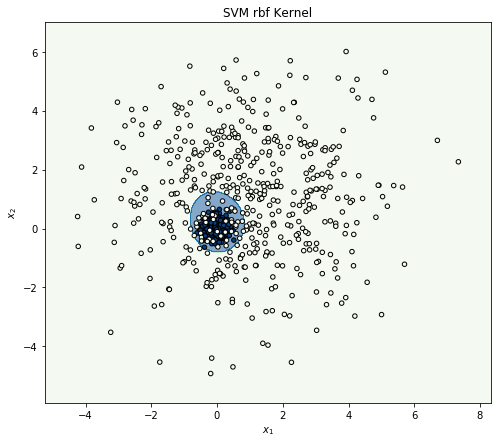

Test error: 5.20%


In [100]:
kernel = 'rbf'
sigma = 1.
C = 1.
model = KernelSVM(C=C, kernel=kernel, sigma=sigma)
y_pred = model.fit(X_train, y_train).predict(X_test)
plot_decision_function(model, X_test, y_test,
                       title='SVM {} Kernel'.format(kernel))
print('Test error: {:.2%}'.format(error(y_pred, y_test)))

In [26]:
model.support_vector_indices

array([20, 45, 67, 70, 76])